In [13]:
import pandas as pd
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import math 
import warnings
warnings.filterwarnings('ignore')

In [14]:
# ignore z axis
def get_features(df,key):
    df_feature=df[df["Key"]==key]
    df_feature=df_feature[['ProductCode', 'LowerBound_X', 'LowerBound_Y',
       'UpperBound_X', 'UpperBound_Y', 'Position_X',
       'Position_Y']]
    df_feature=df_feature.dropna()
    df_feature['Position_X']=df_feature['Position_X'].astype('float')
    df_feature['Position_Y']=df_feature['Position_Y'].astype('float')
    df_feature['LowerBound_X']=df_feature['LowerBound_X'].astype('float')
    df_feature['LowerBound_Y']=df_feature['LowerBound_Y'].astype('float')
    df_feature['UpperBound_X']=df_feature['UpperBound_X'].astype('float')
    df_feature['UpperBound_Y']=df_feature['UpperBound_Y'].astype('float')
    
    return df_feature

In [15]:
def get_centroid(df):
    x=((df['UpperBound_X']+df['LowerBound_X'])/2).sum()/len(df)
    y=((df['UpperBound_Y']+df['LowerBound_Y'])/2).sum()/len(df)
    return x,y

In [16]:
def get_radius(upper_x,upper_y,lower_x,lower_y,x,y,eps=0,rank_of_radius=0):
    radius_list=[]
    radius_list.append(abs(upper_x-x)) 
    radius_list.append(abs(lower_x-x))
    radius_list.append(abs(upper_y-y))
    radius_list.append(abs(lower_y-y))
    # sorted all the radius
    radius_list=sorted(radius_list, reverse=True) 
    # 0 is the biggest radius, then 1, then 2, then 3
    return radius_list[rank_of_radius]+eps

In [17]:
def Calculate_SSE(df,newdf):
    SSE=0
    Groups=list(set(newdf['group']))
    for i in Groups:
        Centorid_x=newdf['mean_X'][newdf['group']==i]
        Centorid_y=newdf['mean_Y'][newdf['group']==i]
        
        Position=df[['Position_X','Position_Y']][df['group']==i]
        Bound=df[['UpperBound_X','LowerBound_X','UpperBound_Y','LowerBound_Y']][df['group']==i]
        Boundary={'Position_X':[],'Position_Y': []}
        for j in range(len(Position)):
            X=Position['Position_X'].iloc[j]
            Y=Position['Position_Y'].iloc[j]
            # Create 4 new points and assign their cluster as their mother point
            Upper_x=Bound['UpperBound_X'].iloc[j]
            Lower_x=Bound['LowerBound_X'].iloc[j]
            Upper_y=Bound['UpperBound_Y'].iloc[j]
            Lower_y=Bound['LowerBound_Y'].iloc[j]
            # Y bound
            Boundary['Position_X'].append(X)
            Boundary['Position_X'].append(X)
            Boundary['Position_Y'].append(Upper_y)
            Boundary['Position_Y'].append(Lower_y)
            # X bound
            Boundary['Position_X'].append(Upper_x)
            Boundary['Position_X'].append(Lower_x)
            Boundary['Position_Y'].append(Y)
            Boundary['Position_Y'].append(Y)
        Boundary=pd.DataFrame(Boundary)
        Position=Position.append(Boundary)
        SSE+=((Position['Position_X']-Centorid_x)**2).sum()+((Position['Position_Y']-Centorid_y)**2).sum()
    return SSE


In [18]:
def Calculate_silhouette_score(df,newdf):
    from sklearn.metrics import silhouette_score
    Groups=list(set(newdf['group']))
    label=[]
    All_Position=df[['Position_X','Position_Y']][df['group']==-1]
    for i in Groups:
        Centorid_x=newdf['mean_X'][newdf['group']==i]
        Centorid_y=newdf['mean_Y'][newdf['group']==i]
        
        Position=df[['Position_X','Position_Y']][df['group']==i]
        Bound=df[['UpperBound_X','LowerBound_X','UpperBound_Y','LowerBound_Y']][df['group']==i]
        Boundary={'Position_X':[],'Position_Y': []}
        for j in range(len(Position)):
            X=Position['Position_X'].iloc[j]
            Y=Position['Position_Y'].iloc[j]
            # Create 4 new points and assign their cluster as their mother point
            Upper_x=Bound['UpperBound_X'].iloc[j]
            Lower_x=Bound['LowerBound_X'].iloc[j]
            Upper_y=Bound['UpperBound_Y'].iloc[j]
            Lower_y=Bound['LowerBound_Y'].iloc[j]
            # Y bound
            Boundary['Position_X'].append(X)
            Boundary['Position_X'].append(X)
            Boundary['Position_Y'].append(Upper_y)
            Boundary['Position_Y'].append(Lower_y)
            # X bound
            Boundary['Position_X'].append(Upper_x)
            Boundary['Position_X'].append(Lower_x)
            Boundary['Position_Y'].append(Y)
            Boundary['Position_Y'].append(Y)
        Boundary=pd.DataFrame(Boundary)
        Position=Position.append(Boundary)
        All_Position=All_Position.append(Position)
        label=label+[i]*len(Position)
    return silhouette_score(All_Position.values,np.array(label))    

In [19]:
def get_two_closest_groups(df):
    # find the two closest groups and return their distance
    meanx={}
    meany={}
    radius={}
    allgroups=list(set(df['group']))
    for i in range(len(allgroups)):
        meanx[allgroups[i]]=df[df['group']==allgroups[i]]['Position_X'].mean()
        meany[allgroups[i]]=df[df['group']==allgroups[i]]['Position_Y'].mean()
        radius[allgroups[i]]=df[df['group']==allgroups[i]]['radius'].mean()
    # find two closest groups
    distance=1000000
    two_groups=[0,0]
    for i in allgroups:
        for j in allgroups:
            if(i==j):
                continue
            distance_of_two_groups=np.sqrt((meanx[i]-meanx[j])**2+(meany[i]-meany[j])**2)
            distance_of_two_groups=distance_of_two_groups-radius[i]-radius[j]
            if(distance_of_two_groups<distance):
                distance=distance_of_two_groups
                two_groups[0]=i
                two_groups[1]=j
    return two_groups[0],two_groups[1],distance

In [20]:
def RVN_parameter_tuning(df,r_expand=1,rank_of_radius=0,print_current_group=False):
    df1=df.copy()
    df1['group']=list(range(0,len(df1)))
    df1['mean_X']=(df1['UpperBound_X']+df1['LowerBound_X'])/2
    df1['mean_Y']=(df1['UpperBound_Y']+df1['LowerBound_Y'])/2
    df1["radius"]=df1.apply(lambda row : get_radius(row['UpperBound_X'],row['UpperBound_Y'],
                                                    row['LowerBound_X'],row['LowerBound_Y'],
                                                    row['mean_X'], row['mean_Y']), axis = 1)

    SSE=[]
    k_list=[]
    score=[]
    newdf=df1
    # if there is no overlapping point, eps1 + r_expand will add the all radius
    eps1=0 
    k=len(set(newdf['group']))

    while(k>2):
        visited=set()
        old_k=k

        for i in range(0,len(set(newdf['group']))):
            #calculate the distance between centriod
            newdf["point_to_point"]=((newdf['mean_X']-newdf['mean_X'].iloc[i])**2+(newdf['mean_Y']-newdf['mean_Y'].iloc[i])**2)**(0.5)
            #sum of two different radius
            newdf['two_r']=newdf['radius']+newdf['radius'].iloc[i]
            #If the point to the distance is smaller then 2 radius, this two group are overlapped
            newdf['group'][newdf["point_to_point"]<=newdf['two_r']]
            
            change=newdf['group'][newdf["point_to_point"]<=newdf['two_r']].index
            #Add this point to the visited set, to make sure that this point will not be visited again
            visited.add(i)
            #Change the group into mother group
            for j in change:
                if(j in visited):
                    continue
                else:
                    visited.add(j)
                    newdf['group'].loc[j]=i

        ## find root
        for i in range(0,len(newdf)):
            current=newdf["group"].iloc[i]
            origin=current
            root=i
            while(current!=root):
                root=newdf["group"].iloc[current]
                current=newdf["group"].iloc[current]

            newdf["group"].iloc[i]=root

            # update group in main df
            df1["group"][df1["group"]==i]=root 

        # calculate new position for forniture

        newposition={"mean_X":[],"mean_Y":[],"radius":[],"group":[]}
        group=list(set(df1["group"]))

        
        for i in range(0,len(group)):
            temp=df1[df1["group"]==group[i]]
            x,y=get_centroid(temp)
            newposition["mean_X"].append(x)
            newposition["mean_Y"].append(y)
            newposition["group"].append(i)

            upper_x=temp['UpperBound_X'].max()
            upper_y=temp['UpperBound_Y'].max()
            lower_x=temp['LowerBound_X'].min()
            lower_y=temp['LowerBound_Y'].min()

            r=get_radius(upper_x,upper_y,lower_x,lower_y,x,y,eps=eps1,rank_of_radius=rank_of_radius)
            newposition["radius"].append(r)

            # update group in main df
            df1["group"][df1["group"]==group[i]]=i

        newdf=pd.DataFrame(newposition)
        k=len(set(df1["group"]))
        # break if group number is smaller than 2
        if(k<2):
            break
        SSE.append(Calculate_SSE(df1,newdf))
        score.append(Calculate_silhouette_score(df1,newdf))
        k_list.append(k)
        
        if(print_current_group):
            print(k)
        if(old_k==k):
            eps1+=r_expand
        else:
            eps1=0

    return SSE,score, k_list

In [21]:
def RVN_naive(df,K_threshold,r_expand=1,rank_of_radius=0,print_current_group=False):
    df1=df.copy()
    df1['group']=list(range(0,len(df1)))
    df1['mean_X']=(df1['UpperBound_X']+df1['LowerBound_X'])/2
    df1['mean_Y']=(df1['UpperBound_Y']+df1['LowerBound_Y'])/2
    df1["radius"]=df1.apply(lambda row : get_radius(row['UpperBound_X'],row['UpperBound_Y'],
                                                    row['LowerBound_X'],row['LowerBound_Y'],
                                                    row['mean_X'], row['mean_Y']), axis = 1)


    newdf=df1
    k=len(set(newdf['group']))
    # if there is no overlapping point, eps + r_expand will add the all radius
    eps1=0

    
    while(k>K_threshold):
        visited=set()
        old_k=k
        #check any group that is overlapped with others
        for i in range(0,len(set(newdf['group']))):
            newdf["point_to_point"]=((newdf['mean_X']-newdf['mean_X'].iloc[i])**2+(newdf['mean_Y']-newdf['mean_Y'].iloc[i])**2)**(0.5)
            newdf['two_r']=newdf['radius']+newdf['radius'].iloc[i]
            newdf['group'][newdf["point_to_point"]<=newdf['two_r']]
            change=newdf['group'][newdf["point_to_point"]<=newdf['two_r']].index
            # put visited group in visited set and dont visit it again
            visited.add(i)
            for j in change:
                if(j in visited):
                    continue
                else:
                    visited.add(j)
                    # update those group's cluster to it mother group
                    newdf['group'].loc[j]=i

        ## find root
        for i in range(0,len(newdf)):
            current=newdf["group"].iloc[i]
            origin=current
            root=i
            while(current!=root):
                root=newdf["group"].iloc[current]
                current=newdf["group"].iloc[current]

            newdf["group"].iloc[i]=root

            # update group in main df
            df1["group"][df1["group"]==i]=root 

        #  calculate new position and radius for each group

        newposition={"mean_X":[],"mean_Y":[],"radius":[],"group":[]}
        group=list(set(df1["group"]))
        

        for i in range(0,len(group)):
            temp=df1[df1["group"]==group[i]]
            x,y=get_centroid(temp)
            newposition["mean_X"].append(x)
            newposition["mean_Y"].append(y)
            newposition["group"].append(i)

            upper_x=temp['UpperBound_X'].max()
            upper_y=temp['UpperBound_Y'].max()
            lower_x=temp['LowerBound_X'].min()
            lower_y=temp['LowerBound_Y'].min()

            r=get_radius(upper_x,upper_y,lower_x,lower_y,x,y,eps=eps1,rank_of_radius=rank_of_radius)
            newposition["radius"].append(r)

            # update group in main df
            df1["group"][df1["group"]==group[i]]=i

        newdf=pd.DataFrame(newposition)
        k=len(set(df1["group"]))
        if(print_current_group):
            print(f"Current number of groups is {k}")
            
        if(old_k==k):
            eps1+=r_expand
        else:
            eps1=0
    
    
    return df1["group"].values # return an array of cluster

In [22]:
def RVN_approximate(df,K_threshold,print_current_group=False):
    df1=df.copy()
    df1['group']=list(range(0,len(df1)))
    df1['mean_X']=(df1['UpperBound_X']+df1['LowerBound_X'])/2
    df1['mean_Y']=(df1['UpperBound_Y']+df1['LowerBound_Y'])/2
    df1["radius"]=df1.apply(lambda row : get_radius(row['UpperBound_X'],row['UpperBound_Y'],
                                                    row['LowerBound_X'],row['LowerBound_Y'],
                                                    row['mean_X'], row['mean_Y']), axis = 1)


    #eps is always 0 in approximate
    eps=0
    
    newdf=df1
    k=len(set(newdf['group']))

    while(k>K_threshold):
        visited=set()
        old_k=k
        #check any group that is overlapped with others
        for i in range(0,len(set(newdf['group']))):
            newdf["point_to_point"]=((newdf['mean_X']-newdf['mean_X'].iloc[i])**2+(newdf['mean_Y']-newdf['mean_Y'].iloc[i])**2)**(0.5)
            newdf['two_r']=newdf['radius']+newdf['radius'].iloc[i]
            newdf['group'][newdf["point_to_point"]<=newdf['two_r']]
            change=newdf['group'][newdf["point_to_point"]<=newdf['two_r']].index
            # put visited group in visited set and dont visit it again
            visited.add(i)
            for j in change:
                if(j in visited):
                    continue
                else:
                    # update those group's cluster to it mother group
                    visited.add(j)
                    newdf['group'].loc[j]=i

        ## find root
        for i in range(0,len(newdf)):
            current=newdf["group"].iloc[i]
            origin=current
            root=i
            while(current!=root):
                root=newdf["group"].iloc[current]
                current=newdf["group"].iloc[current]

            newdf["group"].iloc[i]=root

            # update group in main df
            df1["group"][df1["group"]==i]=root 

        # calculate new position and radius for each group

        newposition={"mean_X":[],"mean_Y":[],"radius":[],"group":[]}
        group=list(set(df1["group"]))

        for i in range(0,len(group)):
            temp=df1[df1["group"]==group[i]]
            x,y=get_centroid(temp)
            newposition["mean_X"].append(x)
            newposition["mean_Y"].append(y)
            newposition["group"].append(i)

            upper_x=temp['UpperBound_X'].max()
            upper_y=temp['UpperBound_Y'].max()
            lower_x=temp['LowerBound_X'].min()
            lower_y=temp['LowerBound_Y'].min()

            r=get_radius(upper_x,upper_y,lower_x,lower_y,x,y,eps)
            newposition["radius"].append(r)

            # update group in main dataframe
            df1["group"][df1["group"]==group[i]]=i

        newdf=pd.DataFrame(newposition)
        k=len(set(df1["group"]))
        if(print_current_group):
            print(f"Current number of groups is {k}")
        if(old_k==k):
            group1,group2,distance=get_two_closest_groups(df1)
            df1['group'][df1['group']==group1]=group2
            
    return df1["group"].values # return an array of cluster

In [40]:
# find the top 10 Silhouette and pick the lowest SSE as K
def pick_the_best_k(SSE,score, k_list):
    record={}
    record['K']=k_list
    record['SSE']=SSE
    record["Silhouette_score"]=score
    record=pd.DataFrame(record)
    record=record.drop_duplicates()
    record=record.sort_values(by=['Silhouette_score'],ascending=False)
    record=record[record['K']<=60]
    record=record.head(5)
    record.loc[record[['SSE']].idxmin()]
    return(int(record.loc[record[['SSE']].idxmin()]['K']))

# Run only one key and using elbow method to tune the k

In [26]:
# Read data
df=pd.read_csv('sample.csv')
df.head()

,LowerBound_X,LowerBound_Y,UpperBound_X,UpperBound_Y,Position_X,Position_Y
0,26402.77211,-606.40698,26461.67211,-596.40698,26401.77211,-601.40698
1,28195.95284,203.40498,28252.95284,232.40498,28223.95284,217.90498
2,28778.92367,-106.03617,28804.11214,-79.18978,28804.11214,-92.61297
3,28178.23951,-455.85328,28187.23951,-444.85328,28182.23951,-450.35328
4,27513.56311,-695.41647,27527.75311,-673.66647,27527.75311,-673.66647


## Parameter tuning

In [41]:
print(f"Use {1} as the expand speed")
SSE,score, k_list=RVN_parameter_tuning(df,r_expand=expand_speed,print_current_group=True)

Use 1 as the expand speed
524
194
102
43
18
4
2


(array([-500000.,       0.,  500000., 1000000., 1500000., 2000000.,
        2500000., 3000000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

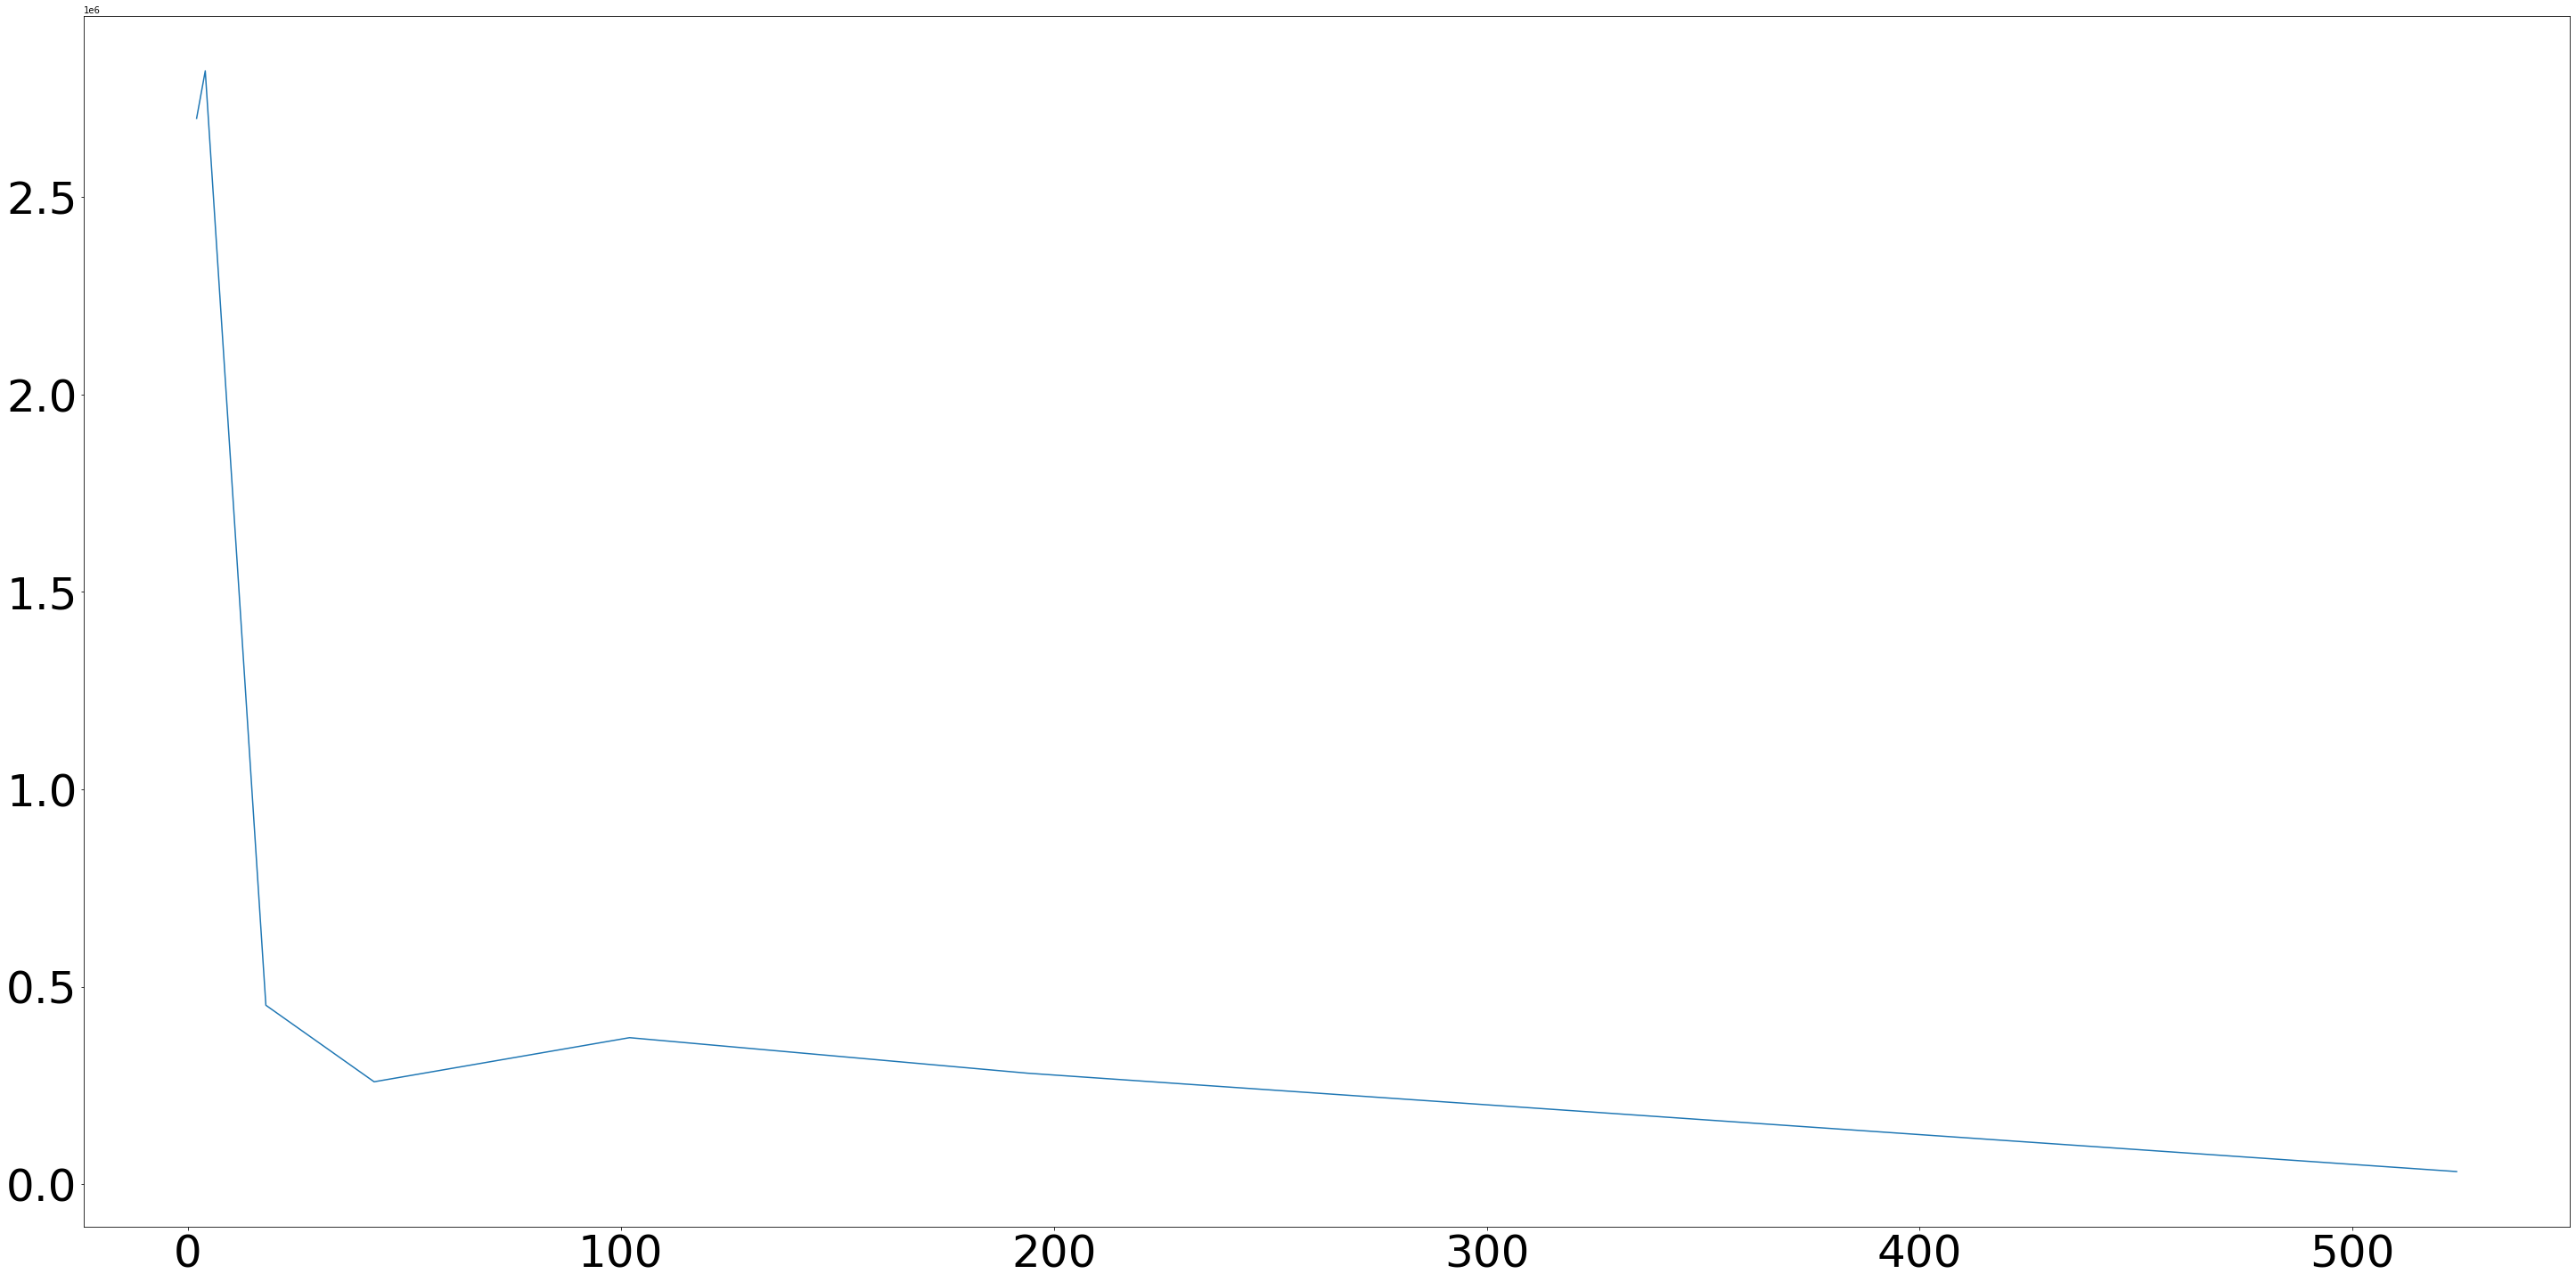

In [42]:
# print SSE 
import seaborn as sns
plt.rcParams['figure.figsize'] = [50, 25]
sns.lineplot(x=k_list,y=SSE)
plt.xticks(fontsize=50)
plt.yticks(fontsize=50)

(array([-0.2 , -0.15, -0.1 , -0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ,
         0.25,  0.3 ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

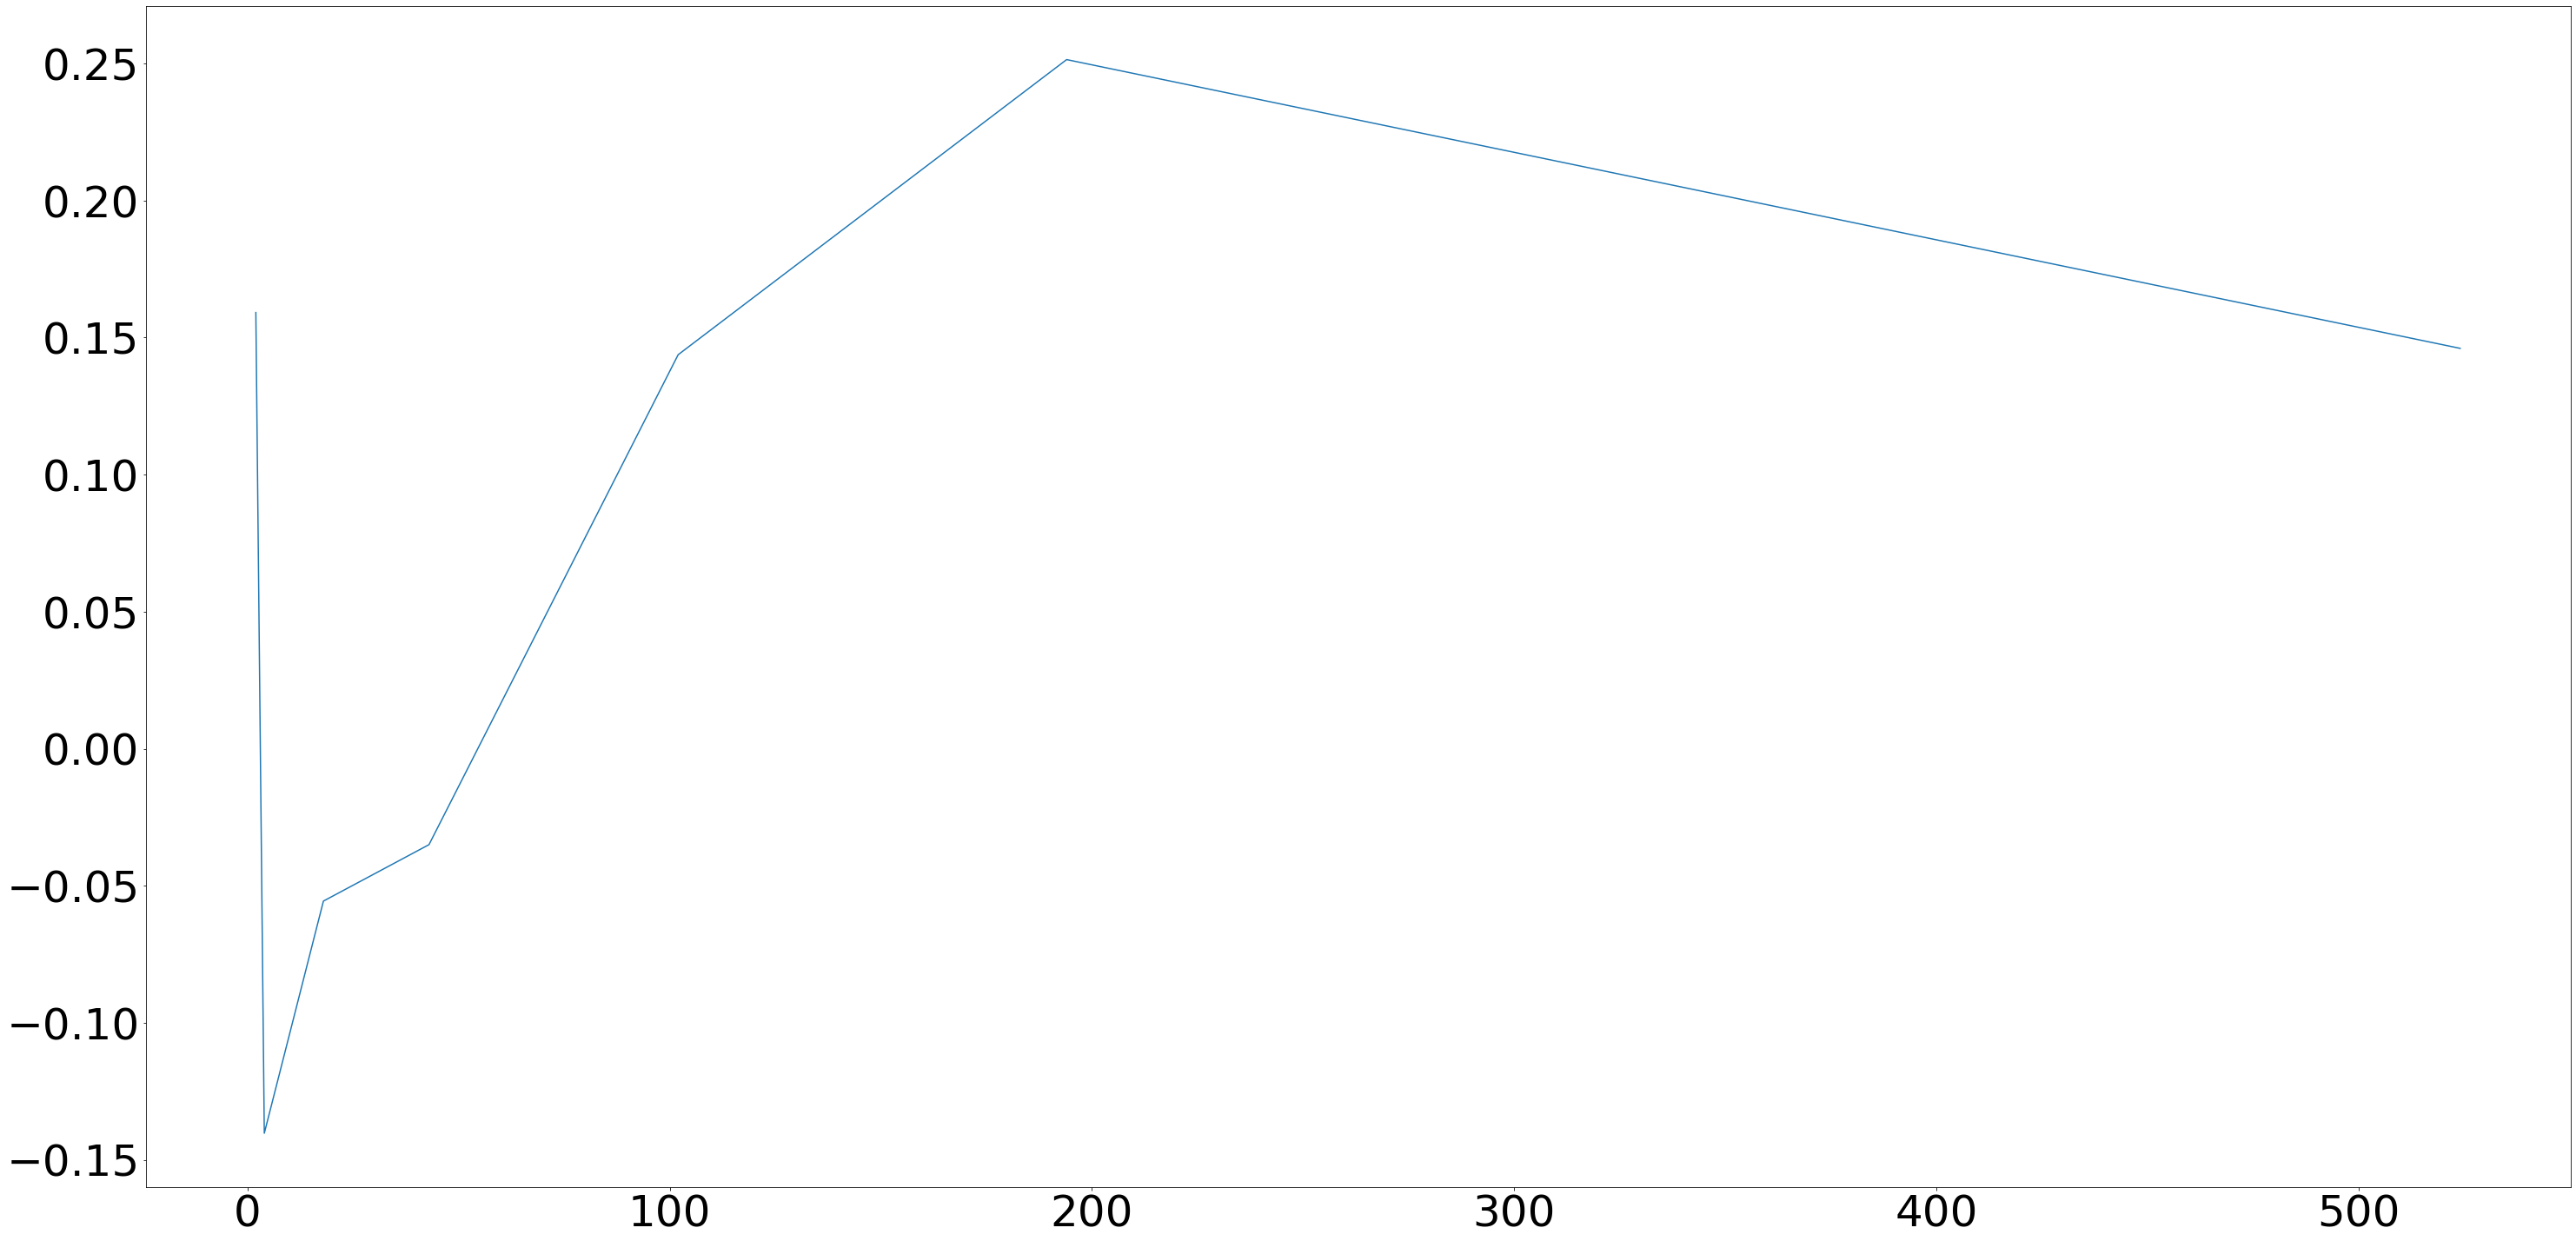

In [43]:
# print silhouette_score
plt.rcParams['figure.figsize'] = [50, 25]
sns.lineplot(x=k_list,y=score)
plt.xticks(fontsize=50)
plt.yticks(fontsize=50)

In [44]:
print('Elbow method, pick k = 20')

Elbow method, pick k = 20


# Run algorithm- naive

In [52]:
groups=RVN_naive(df,50)
df['naive_clusters']=groups

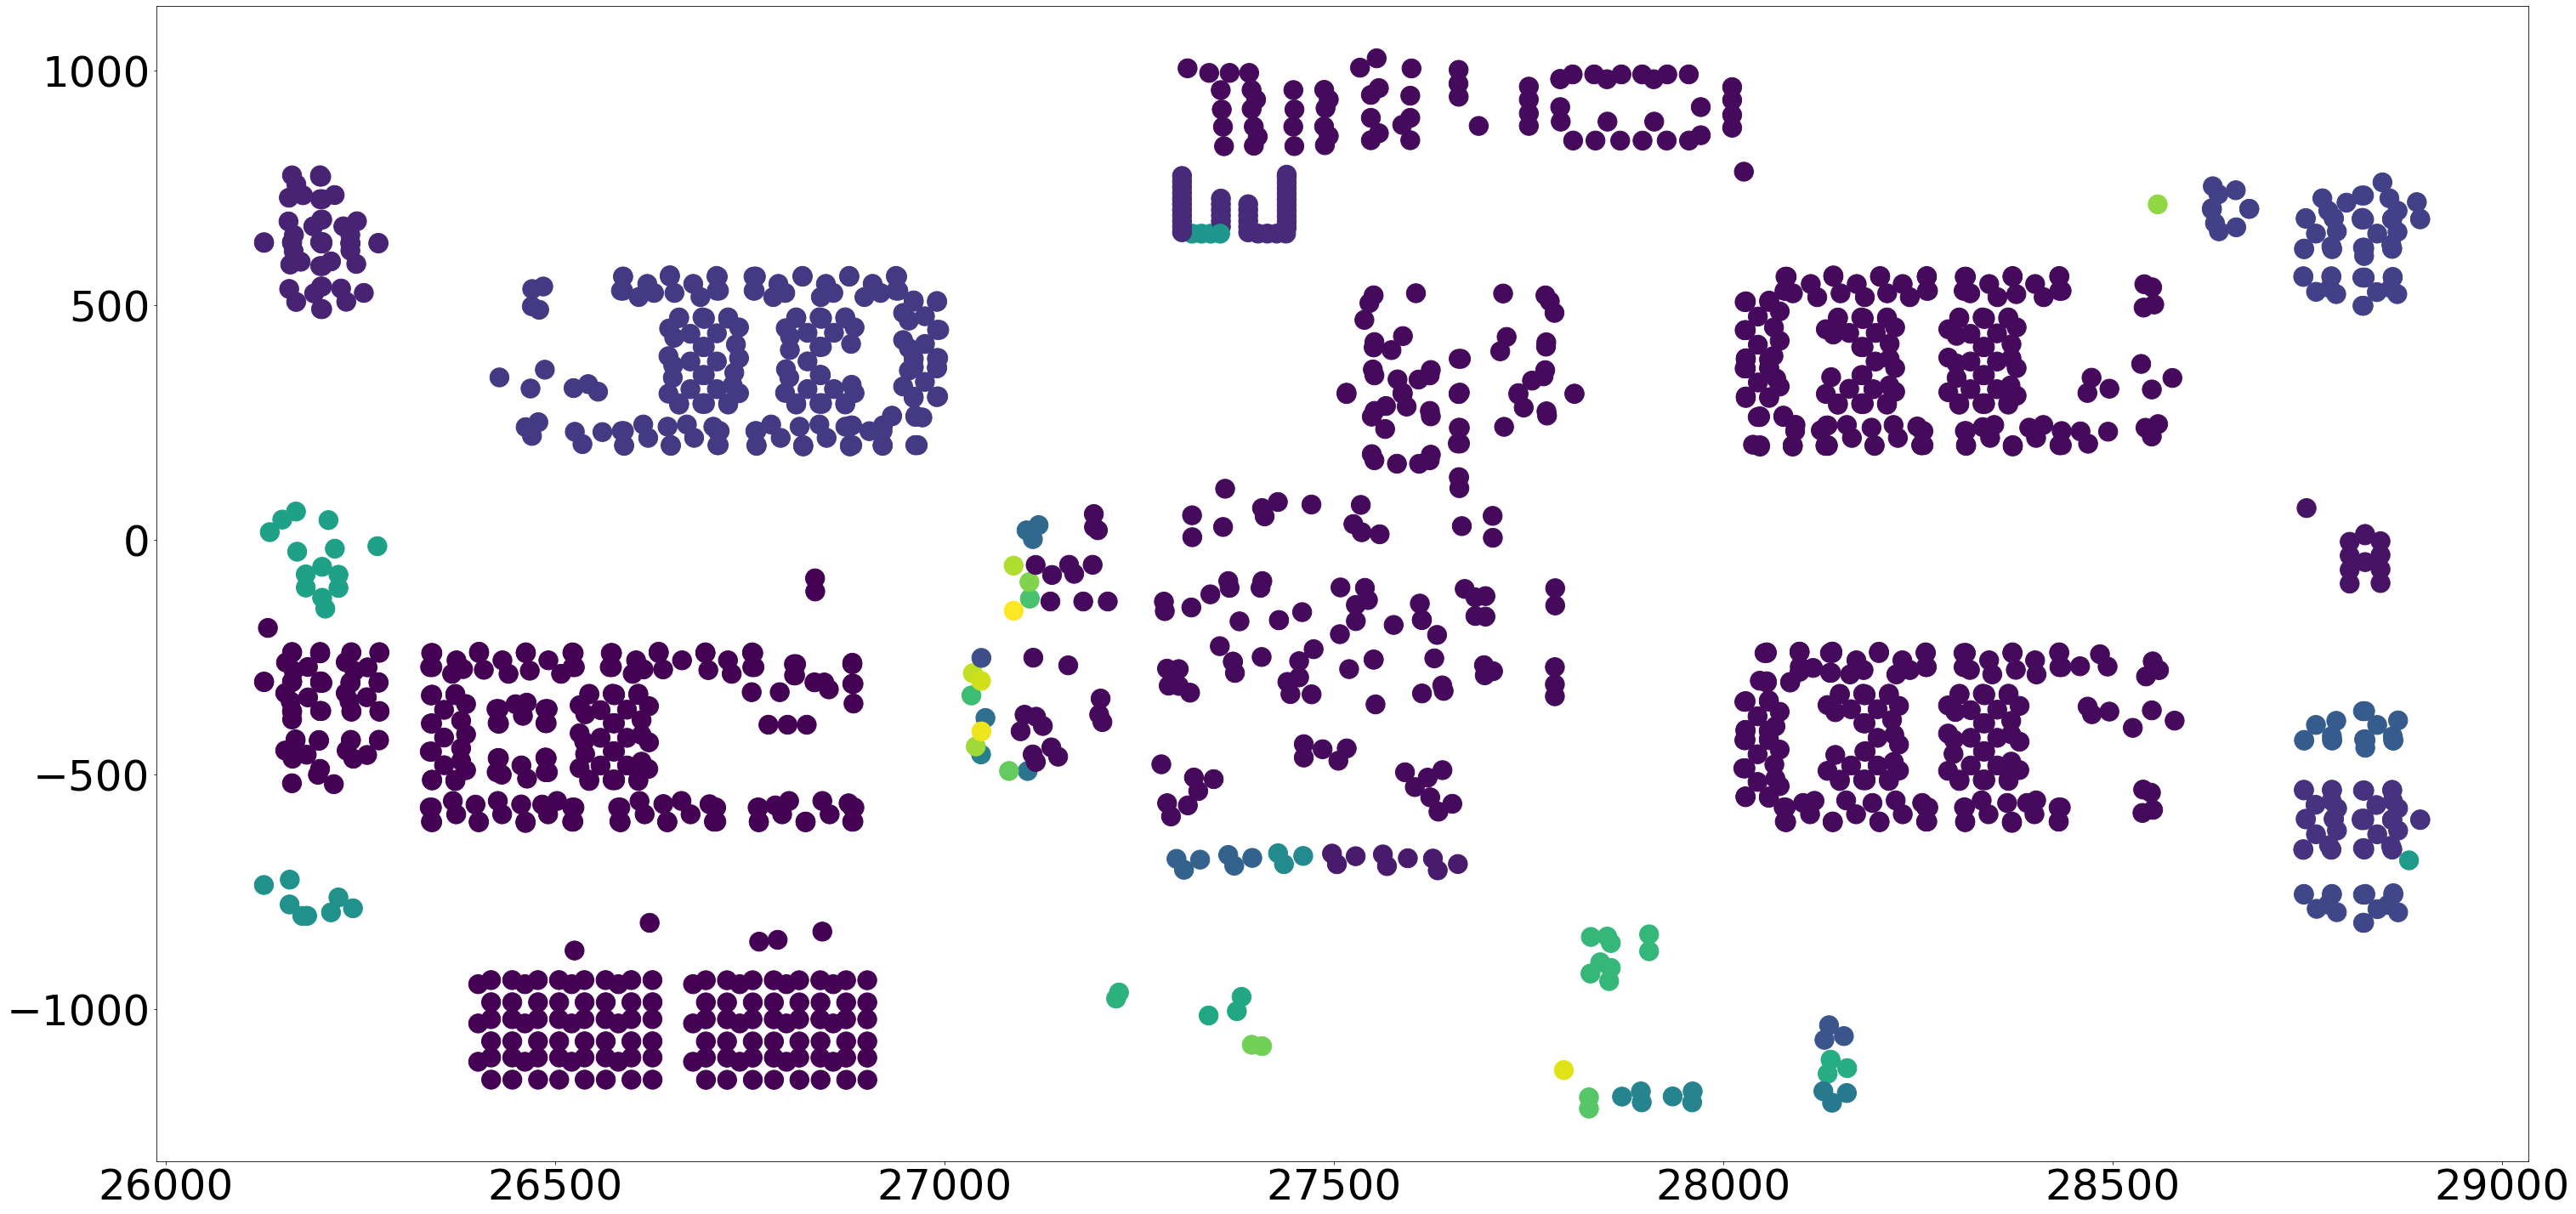

In [53]:
# Plot
plt.rcParams['figure.figsize'] = [50, 25]
plt.scatter(test.Position_X, df.Position_Y,c=df.naive_clusters,s=500)
plt.xticks(fontsize=50)
plt.yticks(fontsize=50)
plt.show()

# Run algorithm- appromixate

In [57]:
groups=RVN_approximate(df,50,print_current_group=True)
df['appromixate_clusters']=groups

Current number of groups is 524
Current number of groups is 194
Current number of groups is 102
Current number of groups is 43


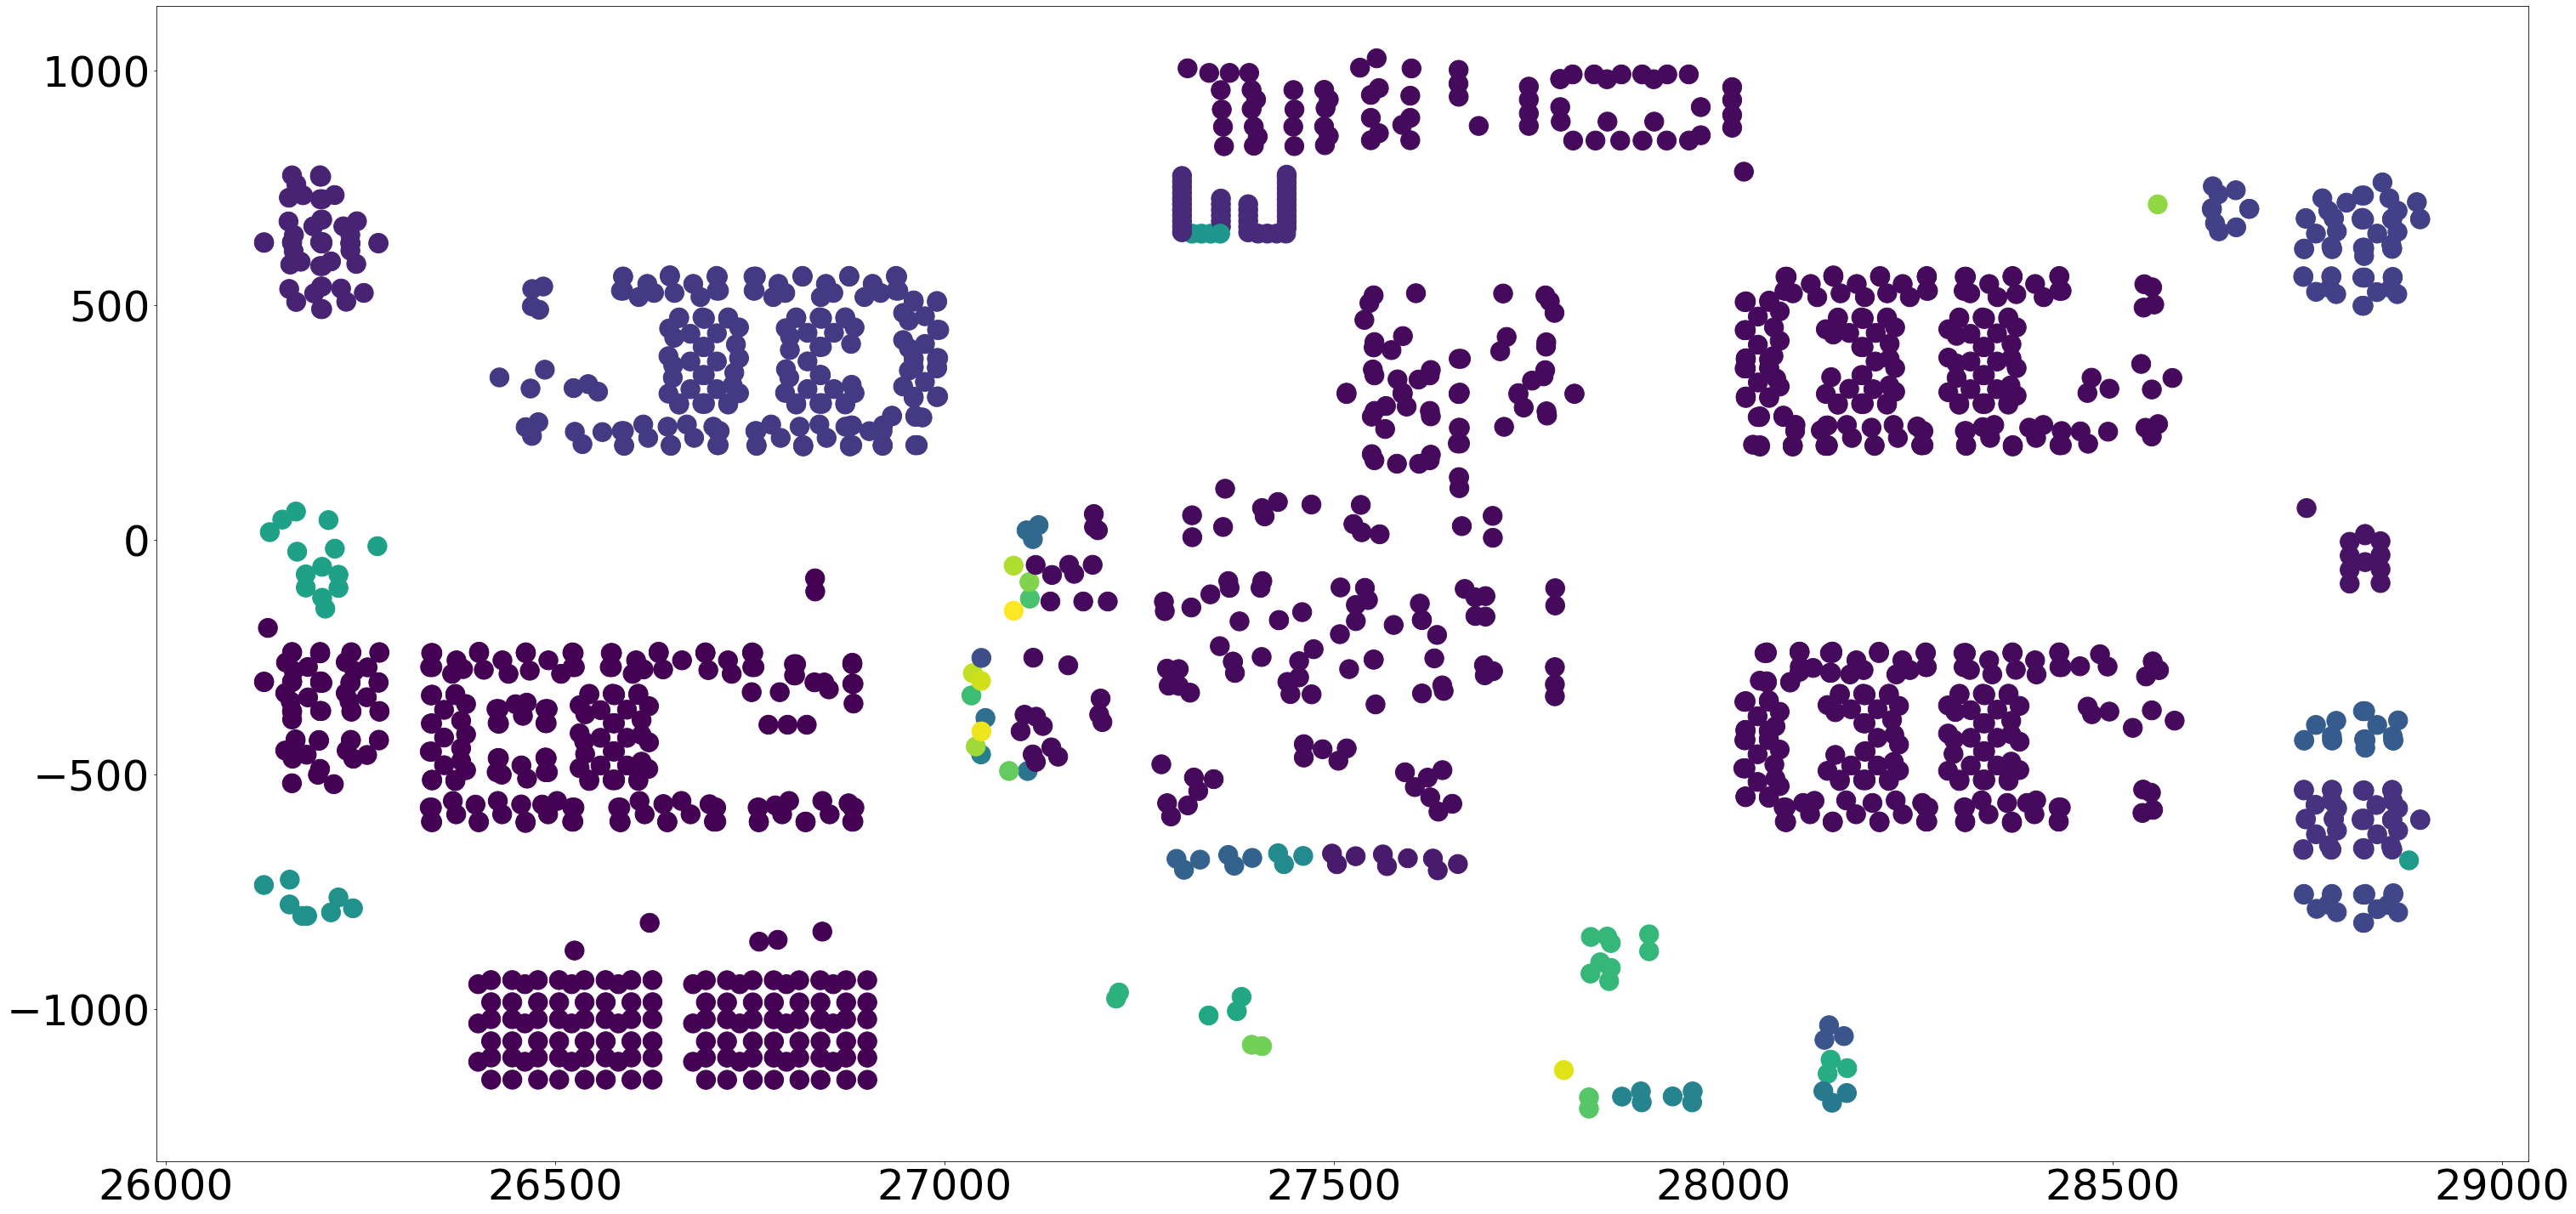

In [58]:
#Plot
plt.rcParams['figure.figsize'] = [50, 25]
plt.scatter(df.Position_X, df.Position_Y,c=df.appromixate_clusters,s=500)
plt.xticks(fontsize=50)
plt.yticks(fontsize=50)
plt.show()